# Import rockphysics Library

In [1]:
import rockphysics as rp

# Load Well Data

In [2]:
# Load log data from a LAS file
my_well = rp.load_well_from_las("DC353-1-SHELL.las")


In [3]:
# Display the names of the curves in the log data
my_well.get_log_names()

['CALI',
 'DEN',
 'DT',
 'DT_SHEAR',
 'DTC',
 'DTS',
 'GR',
 'NEU',
 'NEU_LS',
 'NEU_SS',
 'NEU_UNK',
 'RESDEP',
 'RESMED',
 'RESSLW',
 'FACIES']

In [ ]:
# Determine log types and mnemonics
nomenclature_handler = rp.LogNomenclature()
curve_mnemonics_in_well = my_well.get_log_names()
active_well_type_map = nomenclature_handler.get_log_type_map(curve_mnemonics_in_well)
print(active_well_type_map)

{'CALI': 'CALIPER', 'DEN': 'DENSITY', 'DT': 'P_SONIC', 'DT_SHEAR': 'S_SONIC', 'DTC': 'P_SONIC', 'DTS': 'S_SONIC', 'GR': 'GAMMA_RAY', 'NEU': 'NEUTRON_POROSITY', 'NEU_LS': 'NEUTRON_POROSITY', 'NEU_SS': 'NEUTRON_POROSITY', 'NEU_UNK': 'NEUTRON_POROSITY', 'RESDEP': 'RESISTIVITY', 'RESMED': 'RESISTIVITY', 'RESSLW': 'RESISTIVITY', 'FACIES': 'FACIES'}


# Petrophysical Calculations

In [6]:
# Calculate VSH from GR (replace with your actual GR_clean and GR_shale values)
vshale = rp.vshale_from_GR(my_well.get_log("GR"), gr_clean=0, gr_shale=150)

my_well.add_log("VSH_GR", vshale)

In [7]:
# Calculate density porosity
porosity = rp.density_porosity( my_well.get_log("DEN"), 2.65, 1.0 )
my_well.add_log("PHID", porosity)


In [8]:
# Calculate sonic porosity using Wyllie equation
sonic_porosity = rp.sonic_porosity_wyllie(
    my_well.get_log("DT"))
my_well.add_log("PHIS", sonic_porosity)

In [9]:
# Calculate sonic porosity using Raymer-Hunt_Gardner equation
sonic_porosity = rp.sonic_porosity_rhg(
    my_well.get_log("DT"))
my_well.add_log("PHIRHG", sonic_porosity)

In [10]:

sw = rp.archie_saturation(my_well.get_log("PHID"), my_well.get_log("RESDEP"), 1.0)
my_well.add_log("SW_ARCHIE", sw)

Porosity values must be between 0 and 1.  Clipping to valid range.


# Basic Log Transformations

In [11]:
vp = rp.vp_from_dt(my_well.get_log("DT"))
vs = rp.vs_from_dts(my_well.get_log("DT_SHEAR"))

my_well.add_log("VP", vp)
my_well.add_log("VS", vs)

# Plotting

In [12]:
# Determine log types and mnemonics
nomenclature_handler = rp.LogNomenclature()
curve_mnemonics_in_well = my_well.get_log_names()
active_well_type_map = nomenclature_handler.get_log_type_map(curve_mnemonics_in_well)
print(active_well_type_map)

{'CALI': 'CALIPER', 'DEN': 'DENSITY', 'DT': 'P_SONIC', 'DT_SHEAR': 'S_SONIC', 'DTC': 'P_SONIC', 'DTS': 'DTS', 'GR': 'GAMMA_RAY', 'NEU': 'NEUTRON_POROSITY', 'NEU_LS': 'NEUTRON_POROSITY', 'NEU_SS': 'NEUTRON_POROSITY', 'NEU_UNK': 'NEUTRON_POROSITY', 'RESDEP': 'RESISTIVITY', 'RESMED': 'RESISTIVITY', 'RESSLW': 'RESISTIVITY', 'FACIES': 'FACIES', 'VSH_GR': 'VOLUME_SHALE', 'PHID': 'POROSITY', 'PHIS': 'POROSITY', 'PHIRHG': 'POROSITY', 'SW_ARCHIE': 'WATER_SATURATION', 'VP': 'P_VELOCITY', 'VS': 'S_VELOCITY'}


LogNomenclature instance created successfully. Will use it for type-based styling.
Loaded display settings from: /Users/Jeffrey.J.Roth/Documents/Projects/rock-physics/rockphysics/visualization/../resources/plot_config.yaml


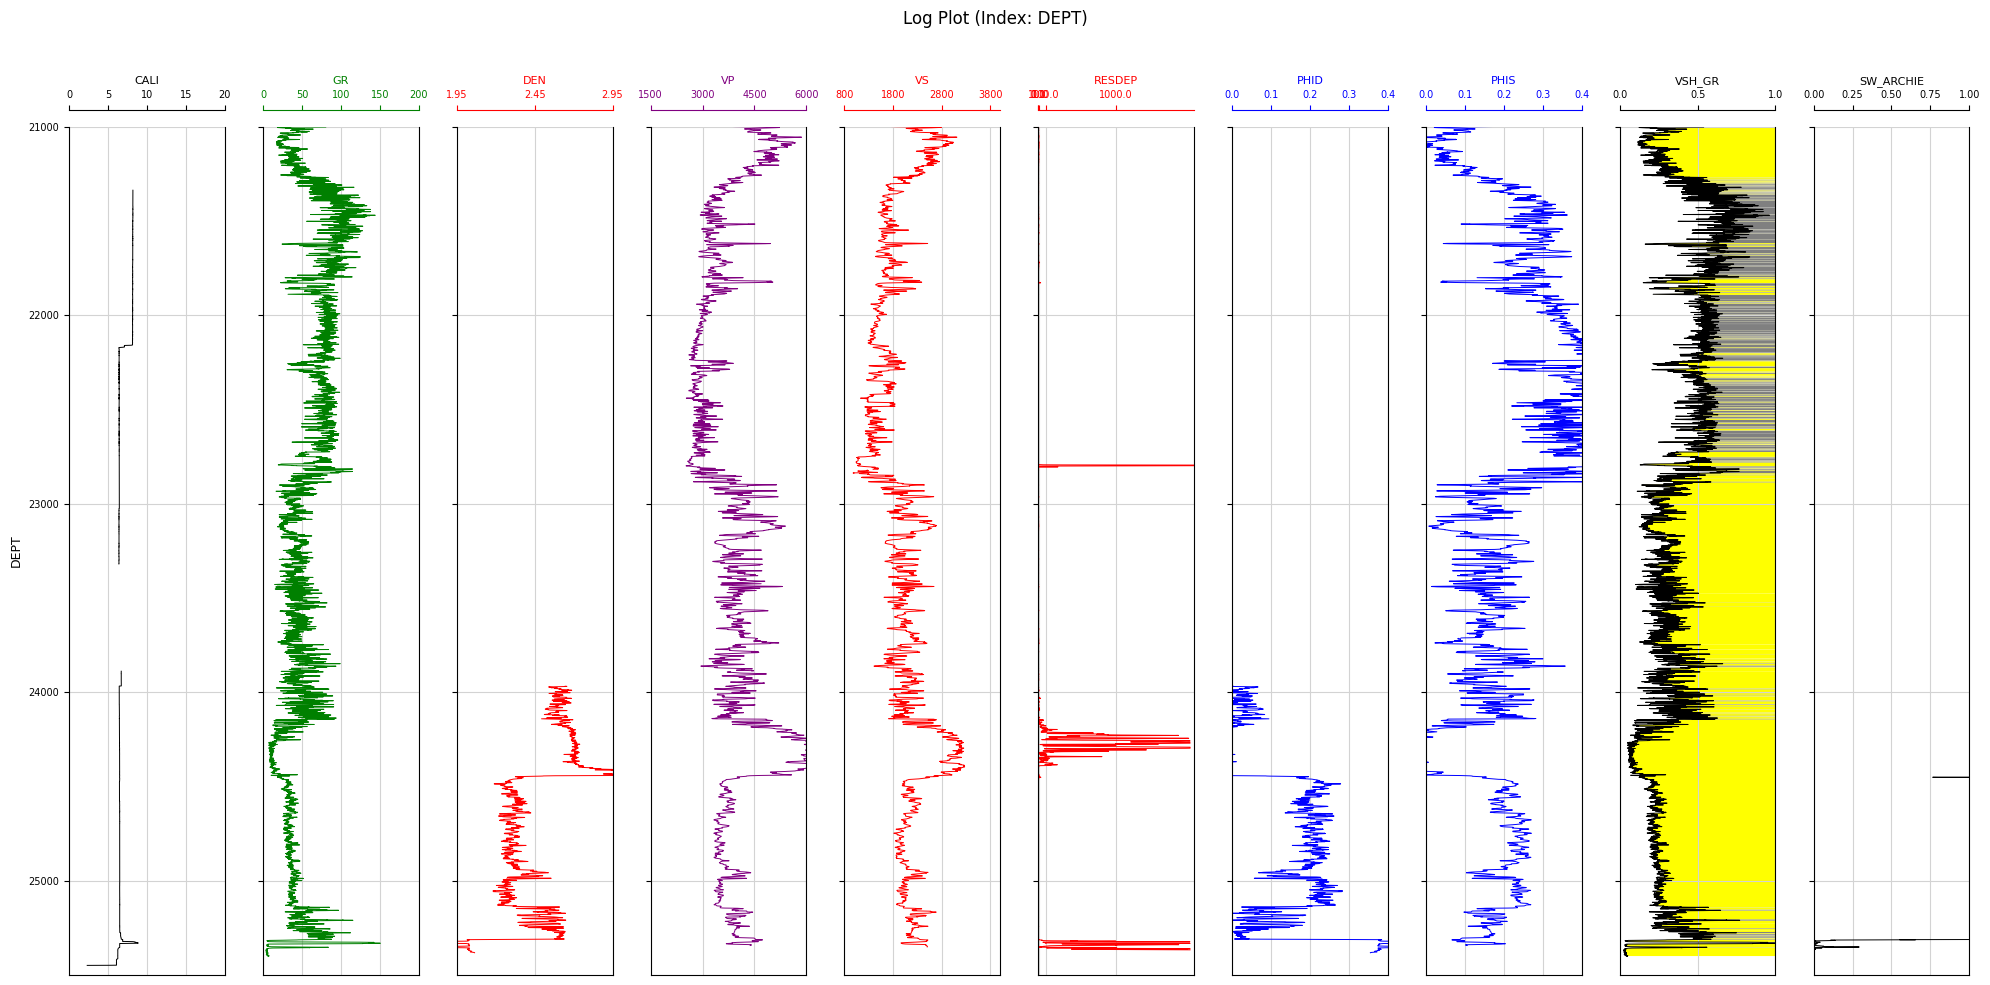

In [12]:
rp.plot_logs(my_well.logs, 21000, 'auto', "CALI", "GR", "DEN", "VP", "VS", "RESDEP", "PHID", "PHIS", "VSH_GR", "SW_ARCHIE")

LogNomenclature instance created successfully. Will use it for type-based styling.
Loaded display settings from: /Users/Jeffrey.J.Roth/Documents/Projects/rockphysics_library/rockphysics/visualization/../resources/plot_config.yaml


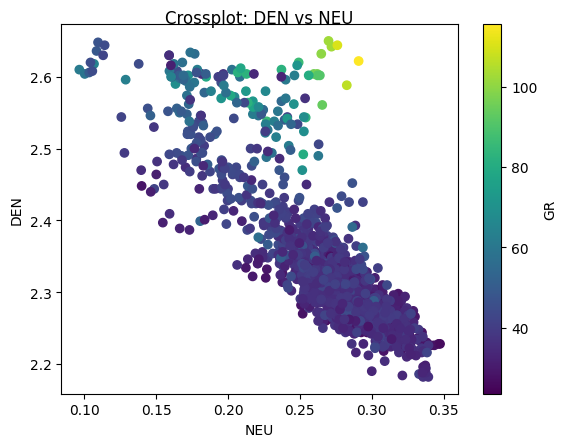

In [13]:
rp.crossplot(my_well.logs, "NEU", "DEN", "GR", 24500, 25250)

# Elastic Log Calculations

In [16]:
# Calculate Vs using Greenberg-Castagna
vs = rp.greenberg_castagna(my_well.get_log("VP"), my_well.get_log("VSH_GR"))
my_well.add_log("VS", vs)

In [17]:
# Calaculate Impedance

ip = rp.acoustic_impedance(my_well.get_log("VP"), my_well.get_log("DEN"))
my_well.add_log("IP", ip)

# Rock Physics Crossplotting

In [18]:
import matplotlib.pyplot as plt

# Define the moduli of the two constituents
modulus_A = 37  # Example value
modulus_B = 1.5  # Example value

# Create a list of volume fractions for constituent B (from 0 to 1)
fractions_B = [i / 100 for i in range(101)]

# Calculate the Reuss average for each volume fraction
reuss_averages = [rp.reuss_average(1 - f, modulus_A, modulus_B) for f in fractions_B]

# Calculate the Voight average for each volume fraction
voigt_averages = [rp.voigt_average(1 - f, modulus_A, modulus_B) for f in fractions_B]

# Calculate bulk modulus log (assuming you have 'Vp' and 'RHOB' logs)
vp = log_data.get_curve("VP")
rhob = log_data.get_curve("RHOB")
bulk_modulus_log = rhob * (vp/1000) ** 2  # Calculate bulk modulus

# Plot the results together
plt.plot(fractions_B, voigt_averages, label="Voigt Average")
plt.plot(fractions_B, reuss_averages, label="Reuss Average")
plt.scatter(vshale, bulk_modulus_log, label="Bulk Modulus Log", marker='x', color='red')
plt.xlabel("Volume Fraction of Constituent B")
plt.ylabel("Elastic Modulus (GPa)")
plt.title("Voigt and Reuss Averages vs. Volume Fraction")
plt.grid(True)
plt.legend()
plt.show()

NameError: name 'log_data' is not defined

# Fluid Substitution

In [ ]:
# Define properties of the fluids and dry rock
K_min, Mu_min = 37, 44    # Example values for the dry rock moduli
K_w, Mu_w = 3, 0    # Example values for the fluid moduli for water
K_o, Mu_o = 1.3, 0.1    # Example values for the new fluid moduli
Sw1 = 0.35
Sw2 = 1

Kq = 36.6
Kc = 75

Rho_o = 0.85
Rho_w = 1.07
Rho_q = 2.65


In [ ]:
# 1. Calculate the elastic moduli of the reservoir (in-situ)
Vp = log_data.get_curve("VP")
Vs = log_data.get_curve("VS")
rhob = log_data.get_curve("DEN")
Ksat1 = rp.bulk_modulus(Vp, Vs, rhob)
msat1 = rp.shear_modulus(Vs, rhob)
# Ksat1, msat1 = rp.calculate_modulus(Vp, Vs, rhob)

In [ ]:
# 2. Calculate effective fluid properties
Kfl1 = rp.reuss_average((Sw1), K_w, K_o)
Kfl2 = rp.reuss_average((Sw2), K_w, K_o)

rho_fl1 = Sw1 * Rho_w + (1 - Sw1) * Rho_o
rho_fl2 = Sw2 * Rho_w + (1 - Sw2) * Rho_o

In [ ]:
# 3. Calculate bulk modulus of the minerals
Kv = rp.voigt_average(1, Kq, Kc)
Kr = rp.reuss_average(1, Kq, Kc)
Ko = rp.hill_average(Kv, Kr)

In [ ]:
# 4. Gassmann Fluid Substitution
por = log_data.get_curve("PHID")

Kdry = rp.dry_modulus(Ksat1, Kfl1, Ko, por)
Ksat2 = rp.gassmann(Kdry, Kfl2, Ko, por)

In [ ]:
# 5. Calculate final density
rho_final = Rho_q * (1-por) + rho_fl2 * por

In [ ]:
# 6. Calculate fluid substituted velocities
Vp_o = rp.p_wave_velocity(Ksat2, msat1, rho_final)
Vs_o = rp.s_wave_velocity(msat1, rho_final)
# Vp_o, Vs_o = rp.calculate_velocity(Ksat2, msat1, rho_final)

In [ ]:
print(Vp_o.mean(), Vs_o.mean())

In [ ]:
log_data.add_curve("Vp_o", Vp_o)
log_data.add_curve("Vs_o", Vs_o)
log_data.add_curve("rho_o", rho_final)

In [ ]:
rp.plot_logs(log_data, 21000, 'auto', "CALI", "GR", "DEN", "VP", "VS", "VSH", "PHID", "Vp_o", "Vs_o", "rho_o")

In [ ]:
nphi = log_data.get_curve("NEU")
rhob = log_data.get_curve("DEN")
nphi_clean = 0
rhob_clean = 2.65
nphi_clay = 40
rhob_clay = 2.5

vclay_nd = rp.vclay_from_neutron_density(nphi, rhob, nphi_clean, rhob_clean, nphi_clay, rhob_clay)
log_data.add_curve("VCLAY_ND", vclay_nd)
rp.plot_logs(log_data, 10500, 'auto', "CALI", "GR", "NEU", "DEN", "VP", "VS", "VSH", "PHID", "Vp_o", "Vs_o", "rho_o", "VCLAY_ND")

# Interactive Vclay Crossplot Analysis

In [ ]:
nphi = log_data.get_curve("NPHI")/100
rhob = log_data.get_curve("RHOB")
depth = log_data.get_curve("DEPTH")
rp.interactive_vclay_crossplot(depth, nphi, rhob)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [ ]:
# Initial end-point values (adjust as needed)
nphi = log_data.get_curve("NPHI")/10
rhob = log_data.get_curve("RHOB")
nphi_clean_init = 0.05
rhob_clean_init = 2.65
nphi_clay_init = 0.45
rhob_clay_init = 2.3

In [ ]:
# Create widgets for end-point values
nphi_clean_widget = widgets.FloatSlider(value=nphi_clean_init, min=-0.1, max=0.5, step=0.01, description="NPHI_clean")
rhob_clean_widget = widgets.FloatSlider(value=rhob_clean_init, min=2.5, max=2.8, step=0.01, description="RHOB_clean")
nphi_clay_widget = widgets.FloatSlider(value=nphi_clay_init, min=0.3, max=0.7, step=0.01, description="NPHI_clay")
rhob_clay_widget = widgets.FloatSlider(value=rhob_clay_init, min=2.0, max=2.5, step=0.01, description="RHOB_clay")

In [ ]:
def calculate_vclay_neutron_density_xplot(nphi, rhob, nphi_clean, rhob_clean, nphi_clay, rhob_clay):
    vclay_nphi = (nphi - nphi_clean) / (nphi_clay - nphi_clean)
    vclay_rhob = (rhob_clay - rhob) / (rhob_clay - rhob_clean)
    vclay = (vclay_nphi + vclay_rhob) / 2
    vclay = vclay.clip(lower=0, upper=1)
    return vclay

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(rhob, nphi, s=10)
plt.xlabel("RHOB (g/cm3)")
plt.ylabel("NPHI (p.u.)")
plt.title("Neutron-Density Crossplot")

# Plot clean sandstone and clay lines
plt.plot([rhob_clean, rhob_clay], [nphi_clean, nphi_clay], 'r-', label='Clay-Sandstone Line')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Vclay
vclay = calculate_vclay_neutron_density_xplot(nphi, rhob, nphi_clean, rhob_clean, nphi_clay, rhob_clay)
print("Calculated Vclay (first 10 values):")
print(vclay.head(10))

In [ ]:
def update_plot(nphi_clean, rhob_clean, nphi_clay, rhob_clay):
    plt.figure(figsize=(10, 8))
    # Flipped axes: NPHI on x-axis, RHOB on y-axis
    plt.scatter(nphi, rhob, s=10)
    plt.xlabel("NPHI (p.u.)")
    plt.ylabel("RHOB (g/cm3)")
    plt.title("Neutron-Density Crossplot (Flipped Axes)")

    # Flipped line coordinates
    plt.plot([nphi_clean, nphi_clay], [rhob_clean, rhob_clay], 'r-', label='Clay-Sandstone Line')
    plt.legend()
    plt.grid(True)
    plt.show()

    vclay = calculate_vclay_neutron_density(nphi, rhob, nphi_clean, rhob_clean, nphi_clay, rhob_clay)
    print("Calculated Vclay (first 10 values):")
    print(vclay.head(10))

In [ ]:
# Link widgets to plot update function
widgets.interactive(
    update_plot,
    nphi_clean=nphi_clean_widget,
    rhob_clean=rhob_clean_widget,
    nphi_clay=nphi_clay_widget,
    rhob_clay=rhob_clay_widget,
)

# Synthetics

In [24]:
# a) Load checkshots and create interpolators
import numpy as np
import pandas as pd
checkshots = rp.load_checkshot_data('checkshot.csv')
depth2time, time2depth = rp.create_depth_time_interpolators(checkshots)

# b) Define a target time index (e.g., 2ms sample rate)
min_time = depth2time(my_well.logs.index.min())
max_time = depth2time(my_well.logs.index.max())
target_time_index = pd.Index(np.arange(min_time, max_time, 2.0), name="TWT (ms)")
print("\nInterpolators created.")
print(f"Time at 7000m: {depth2time(7000):.2f} ms")
print(f"Time at 30000m (extrapolated): {depth2time(30000):.2f} ms")
print(f"Depth at 2000ms: {time2depth(2000):.2f} m")

# c) Convert selected logs to the time domain
time_domain_df = rp.convert_well_to_time(my_well, ['IP', 'GR', 'DEN', 'VSH_GR'], depth2time, target_time_index)


Interpolators created.
Time at 7000m: 880.00 ms
Time at 30000m (extrapolated): 3210.00 ms
Depth at 2000ms: 15887.10 m


In [25]:
# --- 4. Generate Synthetic Seismogram ---
# a) Calculate reflectivity from the time-domain AI log
rc_series = rp.calculate_reflectivity(time_domain_df['GR_time'])
time_domain_df['RC_time'] = rc_series

# b) Generate a wavelet
wavelet = rp.generate_ricker_wavelet(peak_frequency=30, length_ms=128, dt_ms=2.0)

<Axes: >

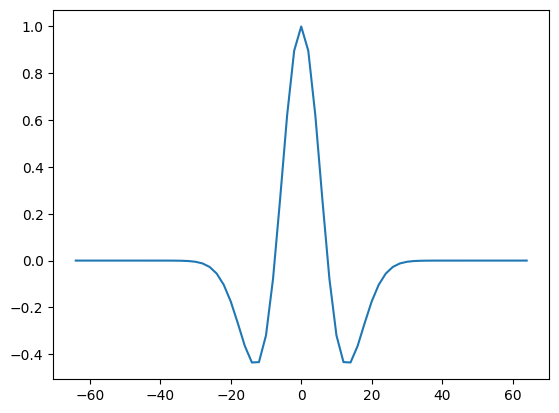

In [26]:
wavelet.plot()

LogNomenclature instance created successfully. Will use it for type-based styling.
Loaded display settings from: /Users/Jeffrey.J.Roth/Documents/Projects/rockphysics_library/rockphysics/visualization/../resources/plot_config.yaml


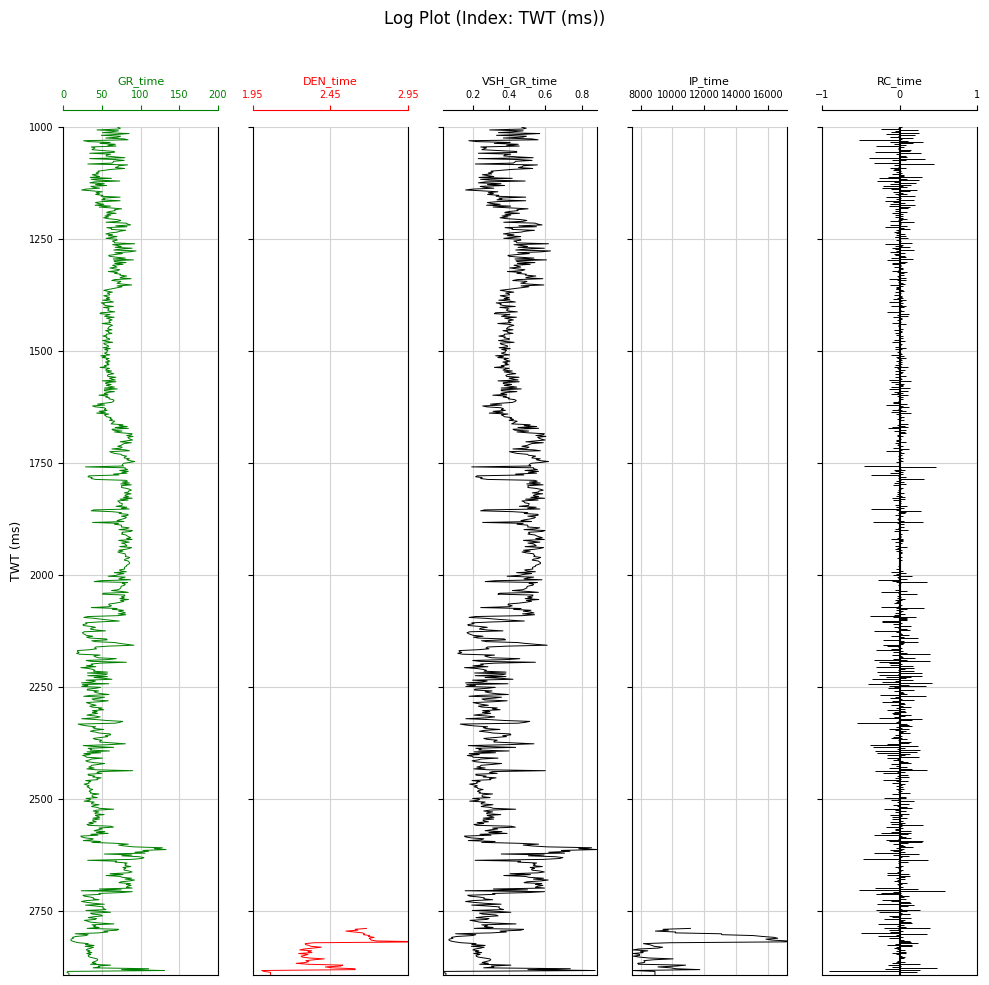

In [27]:
rp.plot_logs(time_domain_df, 1000, 'auto', "GR_time", "DEN_time", "VSH_GR_time", "IP_time", "RC_time")

In [28]:
# c) Convolve to create the synthetic trace
synthetic_trace = rp.create_synthetic(rc_series, wavelet)

# d) Combine results into one DataFrame for plotting
final_df = time_domain_df.copy()
final_df['RC_time'] = rc_series
final_df['Synthetic'] = synthetic_trace

print("--- Step 4: Synthetic Seismogram Generated ---")
print(final_df.head())
print("\n")

--- Step 4: Synthetic Seismogram Generated ---
            IP_time    GR_time  DEN_time  VSH_GR_time   RC_time  Synthetic
TWT (ms)                                                                  
975.290034      NaN        NaN       NaN          NaN       NaN   0.108849
977.290034      NaN  31.133476       NaN     0.207557  0.361568   0.149721
979.290034      NaN  66.397571       NaN     0.442650 -0.292604   0.173304
981.290034      NaN  36.337048       NaN     0.242247 -0.073912   0.173962
983.290034      NaN  31.335222       NaN     0.208901  0.303179   0.148932




LogNomenclature instance created successfully. Will use it for type-based styling.
Loaded display settings from: /Users/Jeffrey.J.Roth/Documents/Projects/rockphysics_library/rockphysics/visualization/../resources/plot_config.yaml


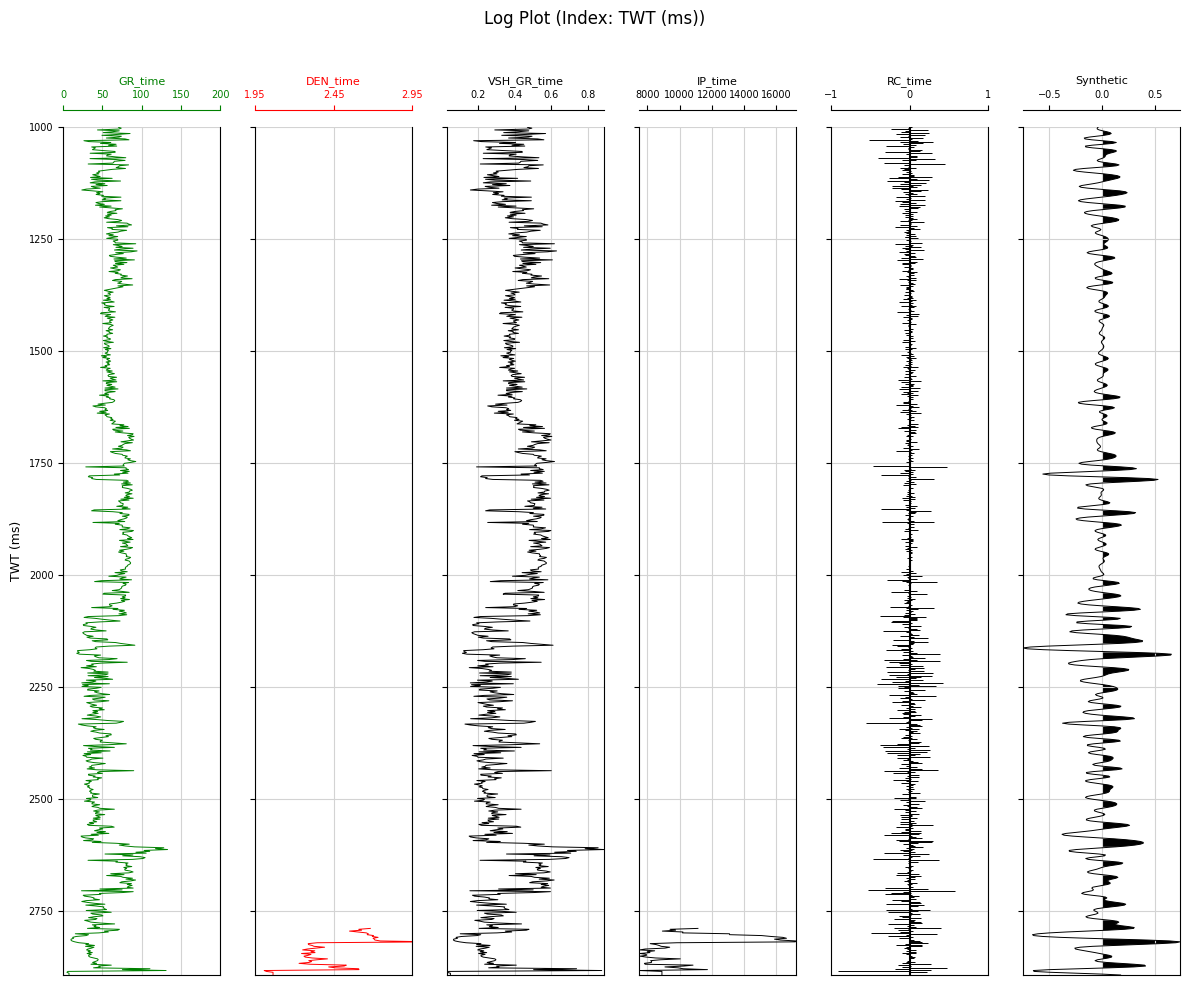

In [30]:
rp.plot_logs(final_df, 1000, 'auto', "GR_time", "DEN_time", "VSH_GR_time", "IP_time", "RC_time", "Synthetic")

# Tops and Interval Calculations

In [31]:
# Load tops data from a CSV file
tops_filepath = "dummy_tops.csv"  # Replace with your actual tops file path
tops_data = rp.load_tops(tops_filepath)
print("\nLoaded Tops Data:")
print(tops_data)


Loaded Tops Data:
     name  depth      source
0   Top A  21400  Geologist1
1   Top B  22800  Geologist1
2  Base B  24200  Geologist1
3   Top C  25100  Geologist1


In [32]:
my_well = rp.load_well_from_las("DC353-1-SHELL.las")

In [33]:
# Calculate VSH (replace with your actual GR_clean and GR_shale values)
vshale = rp.vshale_from_GR(my_well.get_log("GR"), gr_clean=0, gr_shale=150)

my_well.add_log("VSH", vshale)

In [34]:
my_well.get_log_names()

['CALI',
 'DEN',
 'DT',
 'DT_SHEAR',
 'DTC',
 'DTS',
 'GR',
 'NEU',
 'NEU_LS',
 'NEU_SS',
 'NEU_UNK',
 'RESDEP',
 'RESMED',
 'RESSLW',
 'FACIES',
 'VSH']

In [35]:
my_well.add_tops_from_df(tops_data, "name", "depth")

In [36]:
my_well.tops

{'Top A': 21400, 'Top B': 22800, 'Base B': 24200, 'Top C': 25100}

In [37]:
intervals = my_well.get_intervals()
print(intervals)

[('Top A', 21400, 'Top B', 22800), ('Top B', 22800, 'Base B', 24200), ('Base B', 24200, 'Top C', 25100)]


In [38]:
# 4. Run the interval summary
print("\n--- Interval Summary ---")
summary = my_well.summarize_intervals(
    vsh_curve='VSH',
    vsh_cutoff=0.5,
    phi_curve='PHIE',
    phi_cutoff=0.1,
    sw_curve='SW',
    sw_cutoff=0.5,
    avg_curves=['GR', 'PHIE']
)

print(summary)


--- Interval Summary ---
          Base  TopMD  BaseMD  gross_thickness  net_sand  ntg_sand  net_pay  \
Top                                                                           
Top A    Top B  21400   22800           1400.0     369.5  0.263929      0.0   
Top B   Base B  22800   24200           1400.0    1323.0  0.945000      0.0   
Base B   Top C  24200   25100            900.0     900.0  1.000000      0.0   

           GR_avg  PHIE_avg  
Top                          
Top A   81.918183       NaN  
Top B   46.249973       NaN  
Base B  29.593960       NaN  


In [40]:
my_well.summarize_intervals(
    vsh_curve='VSH',
    vsh_cutoff=0.5,
    phi_curve='PHIE',
    phi_cutoff=0.1,
    sw_curve='SW',
    sw_cutoff=0.5,
    avg_curves=['GR', 'PHIE']
)

,Base,TopMD,BaseMD,gross_thickness,net_sand,ntg_sand,net_pay,GR_avg,PHIE_avg
Top,,,,,,,,,
Top A,Top B,21400,22800,1400.0,369.5,0.263929,0.0,81.918183,NaN
Top B,Base B,22800,24200,1400.0,1323.0,0.945000,0.0,46.249973,NaN
Base B,Top C,24200,25100,900.0,900.0,1.000000,0.0,29.593960,NaN
